# Import statements
Following packages are necessary:

In [4]:
import random
import utils
import os
import imageio
import json
import closs
import ccall

from simplegen import SIMPLESequence
from lastengen import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from unet import UNet
from unet import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [5]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [6]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 7.4) Supervised Euclidean for LASTENA BS=4
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [19]:
store_path = 'experiments/7_4_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENA/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENA/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENA/validation'
#path_validation_2 = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENA/test'

path_fixed = r'D:\Julian\data\LASTENA\fix'
path_train = r'D:\Julian\data\LASTENA\train'
path_validation = r'D:\Julian\data\LASTENA\validation'
path_validation_2 = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTENA\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [20]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [21]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [22]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

val_gen_2 = LASTENSequence(path_validation_2,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

timelogger = ccall.TimeHistory(store_path)
vallogger = ccall.ValidationHistory(store_path, val_gen_2)
logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.{epoch:02d}.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best, vallogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [ ]:
model.load_weights(store_path + "/weights.50.hdf5")

In [23]:
model.fit(train_gen,
          epochs=100,
          initial_epoch=50,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 840 steps, validate for 180 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

839/840 [============================>.] - ETA: 0s - loss: 1349.8408 - maed: 28.9907WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 183s 217ms/step - loss: 1349.0133 - maed: 28.9813 - val_loss: 1232.1411 - val_maed: 28.7403
Epoch 2/100
839/840 [============================>.] - ETA: 0s - loss: 515.4189 - maed: 17.8119WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 154s 183ms/step - loss: 515.0526 - maed: 17.8045 - val_loss: 422.7169 - val_maed: 16.2267
Epoch 3/100
839/840 [============================>.] - ETA: 0s - loss: 330.9732 - maed: 14.2123WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 152s 181ms/step - loss: 331.0035 - maed: 14.2115 - val_loss: 446.7629 - val_maed: 16.8756
Epoch 4/100
839/840 [============================>.] - ETA: 0s - loss: 265.2695

Epoch 22/100
839/840 [============================>.] - ETA: 0s - loss: 42.3877 - maed: 5.0202WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 160s 190ms/step - loss: 42.3627 - maed: 5.0185 - val_loss: 71.9092 - val_maed: 6.3002
Epoch 23/100
839/840 [============================>.] - ETA: 0s - loss: 41.7114 - maed: 4.9933WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 163s 194ms/step - loss: 41.7212 - maed: 4.9942 - val_loss: 83.8410 - val_maed: 6.6709
Epoch 24/100
839/840 [============================>.] - ETA: 0s - loss: 35.9181 - maed: 4.6226- ETA: 1s - loss: 35.9703 - maedWARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 158s 188ms/step - loss: 35.9089 - maed: 4.6218 - val_loss: 87.4420 - val_maed: 6.9186
Epoch 25/100
839/840 [============================>.]

840/840 [==============================] - 156s 185ms/step - loss: 16.5934 - maed: 3.1639 - val_loss: 62.1629 - val_maed: 5.5454
Epoch 43/100
839/840 [============================>.] - ETA: 0s - loss: 15.7613 - maed: 3.0913WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 161s 192ms/step - loss: 15.7527 - maed: 3.0904 - val_loss: 64.5453 - val_maed: 5.7986
Epoch 44/100
839/840 [============================>.] - ETA: 0s - loss: 15.5927 - maed: 3.0804WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 173s 206ms/step - loss: 15.5877 - maed: 3.0800 - val_loss: 71.1600 - val_maed: 6.1643
Epoch 45/100
839/840 [============================>.] - ETA: 0s - loss: 15.3275 - maed: 3.0468WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 169s 201ms/step - loss: 15.3186 - maed: 3.

KeyError: 'val_loss'

# Evaluation
Evaluate the trained network

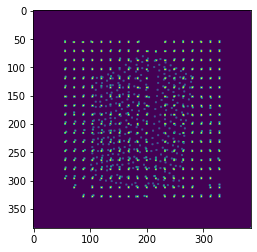

In [24]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 7.5) Supervised Euclidean for LASTENAS BS=4
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [ ]:
store_path = 'experiments/7_5_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/validation'
#path_validation_2 = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/test'

path_fixed = r'D:\Julian\data\LASTENAS\fix'
path_train = r'D:\Julian\data\LASTENAS\train'
path_validation = r'D:\Julian\data\LASTENAS\validation'
path_validation_2 = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTENAS\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [ ]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [ ]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

val_gen_2 = LASTENSequence(path_validation_2,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

timelogger = ccall.TimeHistory(store_path)
vallogger = ccall.ValidationHistory(store_path, val_gen_2)
logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.{epoch:02d}.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best, vallogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [ ]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

# Evaluation
Evaluate the trained network

In [ ]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 7.6) Supervised Euclidean for LASTENS+LASTEN BS=4
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [ ]:
store_path = 'experiments/7_6_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/validation'
#path_validation_2 = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/test'

path_fixed = r'D:\Julian\data\LASTENS_LASTEN\fix'
path_train = r'D:\Julian\data\LASTENS_LASTEN\train'
path_validation = r'D:\Julian\data\LASTENS_LASTEN\validation'
path_validation_2 = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTENS_LASTEN\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [ ]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [ ]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

val_gen_2 = LASTENSequence(path_validation_2,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

timelogger = ccall.TimeHistory(store_path)
vallogger = ccall.ValidationHistory(store_path, val_gen_2)
logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.{epoch:02d}.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best, vallogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [ ]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

# Evaluation
Evaluate the trained network

In [ ]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)